In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum
# from pynrc.obs_nircam import model_to_hdulist, obs_hci
# from pynrc.obs_nircam import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, model_info, obs_wfe, obs_optimize

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import do_plot_contrasts, plot_images, plot_images_swlw

## Define Sources and their Reference PSF Stars

In [4]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [5]:
#                source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band, fov
args_sources = [('epsEri', 3.2,  800, 'K2V', 5084, -0.13, 4.3, 1.67, bp_k,  10)]

ref_sources  = [('delEri', 'K0IV', 5055, +0.13, 3.9, 1.43, bp_k)]

In [6]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'Moonshots/'

In [7]:
# List of filters
args_filter = [('F356W', 'MASK430R', 'CIRCLYOT'),
               ('F444W', 'MASK430R', 'CIRCLYOT')]

#subsize = 320

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## Eps Eri

In [8]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[0.5,10])

# Final source spectrum
sp_sci = src.sp_model

[1.00615174]


In [9]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[2,10])

# Final reference spectrum
sp_ref = ref.sp_model

[0.95088536]


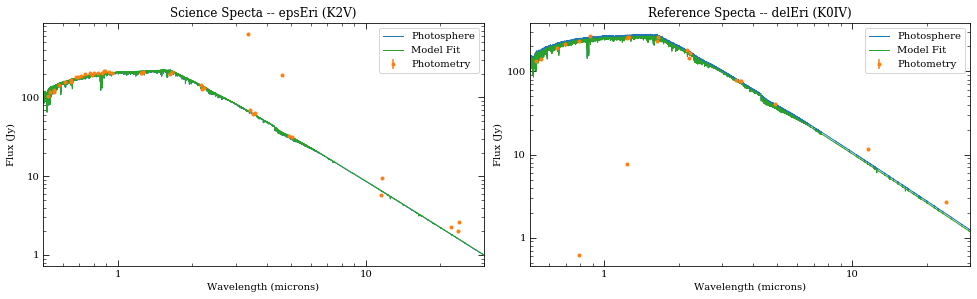

In [10]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

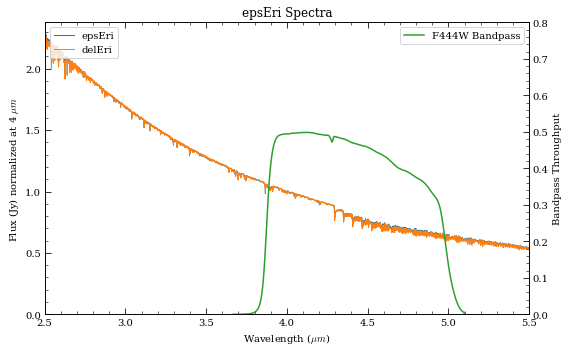

In [11]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3.9) & (w<=4.1)
    sp.convert('Jy')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
bp = pynrc.read_filter(*args_filter[-1])
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_2SEDs.pdf'.format(name_sci.replace(' ','')))

In [12]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='FULL', verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [13]:
for key in filt_keys:
    obs = obs_dict[key]

    # Science observations
    if 'F444W' in key:
        read_mode, ng, nint = ('BRIGHT2', 7, 6)
    else:
        read_mode, ng, nint = ('RAPID', 9, 5)        
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

    # Reference observations
    if 'F444W' in key:
        read_mode, ng, nint = ('BRIGHT2', 9, 5)
    else:
        read_mode, ng, nint = ('RAPID', 9, 5)        
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [53]:
# Saturation Levels
# Only want F444W
#obs = obs_dict[filt_keys[-1]]
#sat_rad = do_sat_levels(obs, plot=True)

# Max Saturation Values
dmax = []
for k in filt_keys:
    print(k)
    obs = obs_dict[k]
    
    imsci = obs.gen_slope_image(exclude_noise=True, quick_PSF=True)
    imref = obs.gen_slope_image(exclude_noise=True, quick_PSF=True, do_ref=True)
    
    ng1 = 2
    sci_sat1 = obs.saturation_levels(ngroup=ng1, image=imsci)
    ref_sat1 = obs.saturation_levels(ngroup=ng1, image=imref, do_ref=True)

    ng2 = obs.multiaccum.ngroup
    sci_sat2 = obs.saturation_levels(ngroup=ng2, image=imsci)
    ng3 = obs.nrc_ref.multiaccum.ngroup
    ref_sat2 = obs.saturation_levels(ngroup=ng3, image=imref, do_ref=True)
    
    print('Max Well NG={}: {:.2f} {:.2f};   Max Well NG=max: {:.2f} {:.2f}'\
          .format(ng1,sci_sat1.max(),ref_sat1.max(),sci_sat2.max(),ref_sat2.max()))

    # Get position of PFS
    xcen, ycen = obs.get_psf_cen()

    # Radius at NG=2
    rho = nrc_utils.dist_image(sci_sat1, center=(xcen,ycen))  # Pixel distances
    sat_mask = sci_sat1 > 0.9
    nsat = np.size(rho[sat_mask])
    rval_sci = rho[sat_mask].max()*obs.pix_scale if nsat>0 else 0
    # Reference PSF
    sat_mask = ref_sat1 > 0.9
    nsat = np.size(rho[sat_mask])
    rval_ref = rho[sat_mask].max()*obs.pix_scale if nsat>0 else 0
    
    print('rmax = ({:.2f}, {:.2f}) arcsec'.format(rval_sci, rval_ref))


F356W_MASK430R_CIRCLYOT
Max Well NG=2: 2.79 3.28;   Max Well NG=max: 12.54 14.78
rmax = (1.27, 1.27) arcsec
F444W_MASK430R_CIRCLYOT
Max Well NG=2: 2.40 2.82;   Max Well NG=max: 8.40 12.67
rmax = (1.47, 1.47) arcsec


In [14]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll)
curves_F444W = curves_dict[filt_keys[-1]]

# Roll1 - Roll2
curves_dict = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, no_ref=True)
curves_F444W2 = curves_dict[filt_keys[-1]]

F444W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [30]:
pynrc._reload()

import sys
del sys.modules['pynrc.obs_nircam']


pynrc reloaded


In [33]:
pynrc._reload()

import sys
del sys.modules['pynrc.nb_funcs']

# Observation Definitions
from pynrc.nb_funcs import make_key, model_info, obs_wfe, obs_optimize

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import do_plot_contrasts, plot_images, plot_images_swlw

pynrc reloaded


In [35]:
from pynrc.obs_nircam import planet_mags

{1: (15.536001277669563, 15.536001277669563)}

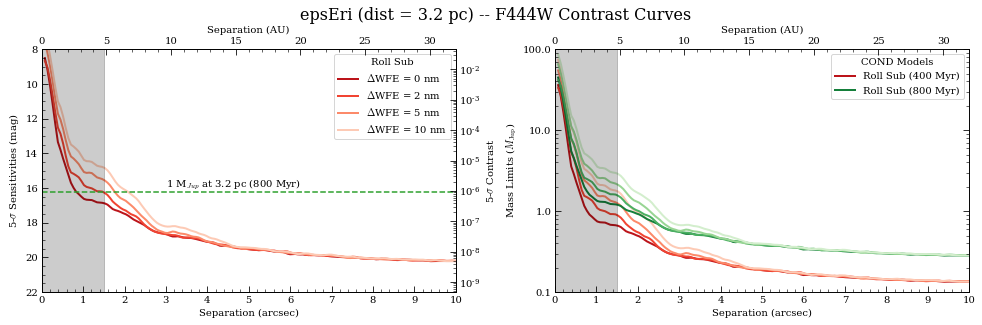

In [58]:
sat_rad = 1.5
obs = obs_dict[filt_keys[-1]]
fig, axes = do_plot_contrasts(None, curves_F444W2, nsig, wfe_list, obs, 400, age2=800, 
                              sat_rad=sat_rad, jup_mag=False,
                              save_fig=False, return_fig_axes=True, yscale2='log')


ax = axes[0]
age_val = 800
pmags = planet_mags(obs, age=age_val, mass_list=[1], av_vals=None)
jmag = pmags[1][0]

xr = ax.get_xlim()
ax.plot(xr, [jmag,jmag], color='C2', ls='--')
txt_mj = u'M$_{Jup}$'
txt = '1 {} at {:.1f} pc ({} Myr)'.format(txt_mj, obs.distance, age_val)
ax.text(3, jmag, txt, horizontalalignment='left', verticalalignment='bottom')

name_sci = obs.sp_sci.name
title_str = '{} (dist = {:.1f} pc) -- {} Contrast Curves'\
    .format(name_sci, obs.distance, obs.filter)
fig.suptitle(title_str, fontsize=16)

fname = "{}_contrast_{}_FULL.pdf".format(name_sci.replace(" ", ""), obs.mask)
fig.savefig(outdir+fname)